# Movie Rec System
- 유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기 별로 있습니다. MovieLens 1M Dataset 사용을 권장합니다.
- 별점 데이터는 대표적인 explicit 데이터입니다. 하지만 implicit 데이터로 간주하고 테스트해 볼 수 있습니다.
- 별점을 시청횟수로 해석해서 생각하겠습니다.
- 또한 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외하겠습니다.

In [1]:
import numpy as np
import scipy
import implicit

print(np.__version__)
print(scipy.__version__)
print(implicit.__version__)

1.21.4
1.7.1
0.4.8


# Load Data and Preprocessing

In [52]:
import os
import pandas as pd

rating_file_path=os.getenv('HOME') + '/aiffel/rec_algo/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()


,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [53]:
# drop below three

ratings = ratings[ratings['ratings'] >= 3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')


orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [54]:
# ratings -> counts

ratings.rename(columns={'ratings' : 'counts'}, inplace=True)

In [55]:
ratings.head()

,user_id,movie_id,counts,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [8]:
# load metadata (movie info)

# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/rec_algo/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()


,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


# EDA

In [9]:
ratings['movie_id'].nunique()

3628

In [10]:
ratings['user_id'].nunique()

6039

In [34]:
top_movies = ratings.groupby('movie_id').sum('counts').sort_values('counts', ascending=False).head(10)
top_movies


,user_id,counts,timestamp
movie_id,,,
2858,9370375,14449,3117376835770
260,8918335,13178,2824985129652
1196,8829164,12648,2800584085770
2028,7616222,11348,2486478228387
1210,8267731,11303,2635697585605
1198,7588272,11179,2400490263497
593,7588813,11096,2425091224615
2571,7313282,10903,2363243946903
2762,7537501,10703,2315566542809


In [35]:
def idx_to_movie(idx):
    try:
        return movies.loc[movies['movie_id'] == idx, 'title']
    except IndexError:
        return 'not found'

In [36]:
movie_id_list = top_movies.index.tolist()

movie_titles = [idx_to_movie(i) for i in movie_id_list]
movie_titles

[2789    American Beauty (1999)
 Name: title, dtype: object,
 257    Star Wars: Episode IV - A New Hope (1977)
 Name: title, dtype: object,
 1178    Star Wars: Episode V - The Empire Strikes Back...
 Name: title, dtype: object,
 1959    Saving Private Ryan (1998)
 Name: title, dtype: object,
 1192    Star Wars: Episode VI - Return of the Jedi (1983)
 Name: title, dtype: object,
 1180    Raiders of the Lost Ark (1981)
 Name: title, dtype: object,
 589    Silence of the Lambs, The (1991)
 Name: title, dtype: object,
 2502    Matrix, The (1999)
 Name: title, dtype: object,
 2693    Sixth Sense, The (1999)
 Name: title, dtype: object,
 585    Terminator 2: Judgment Day (1991)
 Name: title, dtype: object]

In [37]:
# add my own fav

my_fav = ['Shawshank Redemption, The (1994)', 'Matrix, The (1999)', 'Die Hard (1988)', 'Blade Runner (1982)']


In [56]:
ratings.drop('timestamp', axis=1, inplace=True)
ratings.head()

,user_id,movie_id,counts
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [42]:
def movie_to_idx(movie):
    return movies.loc[movies['title'] == movie, 'movie_id'].values[0]

my_fav_id = [movie_to_idx(movie) for movie in my_fav]

In [43]:
my_fav_id

[318, 2571, 1036, 541]

In [64]:
my_watchlist = pd.DataFrame({'user_id' : [6041]*4, 'movie_id': my_fav_id, 'counts' : [3]*4 })

if not ratings.isin({'user_id' : [6041]})['user_id'].any():
    ratings = pd.concat([ratings, my_watchlist])


In [65]:
ratings.tail(10)

,user_id,movie_id,counts
1000202,6040,1089,4
1000203,6040,1090,3
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4
1000208,6040,1097,4
0,6041,318,3
1,6041,2571,3
2,6041,1036,3
3,6041,541,3


<AxesSubplot:>

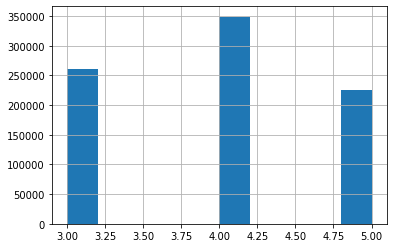

In [49]:
ratings['counts'].hist()

# Create CSR Matrix

In [66]:
from scipy.sparse import csr_matrix

num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()

csr_ratings = csr_matrix((ratings.counts, (ratings.user_id, ratings.movie_id)), shape=(num_user, num_movie))
csr_ratings



ValueError: row index exceeds matrix dimensions

In [68]:
# troubleshoot - redo indexing

user_unique = ratings['user_id'].unique()
movie_unique = ratings['movie_id'].unique()

user_to_idx = {v:k for k, v in enumerate(user_unique)}
movie_to_idx = {v:k for k, v in enumerate(movie_unique)}

In [69]:
temp_user_idx = ratings['user_id'].map(user_to_idx.get).dropna()

if len(temp_user_idx) == len(ratings):
    print('user_to_id success')
    ratings['user_id'] = temp_user_idx
else: 
    print('user_to_idx fail')
    
temp_movie_id = ratings['movie_id'].map(movie_to_idx.get).dropna()

if len(temp_movie_id) == len(ratings):
    print('movie_id_success')
    ratings['movie_id'] = temp_movie_id
    
else:
    print('movie_idx fail')

user_to_id success
movie_id_success


In [70]:
# retry

from scipy.sparse import csr_matrix

num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()

csr_ratings = csr_matrix((ratings.counts, (ratings.user_id, ratings.movie_id)), shape=(num_user, num_movie))
csr_ratings



<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836482 stored elements in Compressed Sparse Row format>

In [71]:
# train als_model

from implicit.als import AlternatingLeastSquares
import os
import numpy as np

os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [72]:
# create model

als_model = AlternatingLeastSquares(factors=100,
                                   regularization=0.05,
                                   use_gpu=False,
                                   iterations=15,
                                   dtype=np.float32)

In [73]:
csr_ratings_transposed = csr_ratings.T
csr_ratings_transposed

<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836482 stored elements in Compressed Sparse Column format>

In [74]:
# train model

als_model.fit(csr_ratings_transposed)

  0%|          | 0/15 [00:00<?, ?it/s]

In [78]:
# model predict

chimin, Matrix = user_to_idx[6041], movie_to_idx[2571]
chimin_vec, Matrix_vec = als_model.user_factors[chimin], als_model.item_factors[Matrix]


In [81]:
# dot product

pred1 = np.dot(chimin_vec, Matrix_vec)
pred1

0.32037222

In [82]:
# acc too low. increase iter

als_model2 = AlternatingLeastSquares(factors=150,
                                   regularization=0.07,
                                   use_gpu=False,
                                   iterations=30,
                                   dtype=np.float32)

als_model2.fit(csr_ratings_transposed)

  0%|          | 0/30 [00:00<?, ?it/s]

In [83]:
# model predict

chimin, Matrix = user_to_idx[6041], movie_to_idx[2571]
chimin_vec, Matrix_vec = als_model2.user_factors[chimin], als_model2.item_factors[Matrix]

pred2 = np.dot(chimin_vec, Matrix_vec)
pred2


0.4120132

In [84]:
# iter 100

als_model3 = AlternatingLeastSquares(factors=100,
                                   regularization=0.1,
                                   use_gpu=False,
                                   iterations=100,
                                   dtype=np.float32)

als_model3.fit(csr_ratings_transposed)

  0%|          | 0/100 [00:00<?, ?it/s]

In [85]:
# model predict

chimin, Matrix = user_to_idx[6041], movie_to_idx[2571]
chimin_vec, Matrix_vec = als_model3.user_factors[chimin], als_model3.item_factors[Matrix]

pred3 = np.dot(chimin_vec, Matrix_vec)
pred3


0.36379868

In [86]:
# american beauty == 2858

ab_idx = movie_to_idx[2858]
ab_vec = als_model.item_factors[ab_idx]

np.dot(chimin_vec, ab_vec)

-0.04219405

# Find Similar Movies

In [88]:
# The Matix == 2571

fav_movie = 2571
movie_id = movie_to_idx[fav_movie]

sim_movie = als_model2.similar_items(movie_id, N=10)
sim_movie

[(124, 0.9999999),
 (92, 0.63790333),
 (62, 0.49535835),
 (200, 0.46915305),
 (141, 0.45541126),
 (145, 0.4536833),
 (375, 0.39579952),
 (317, 0.333599),
 (107, 0.32157695),
 (175, 0.31433475)]

In [93]:
idx_to_movie = {v:k for k, v in movie_to_idx.items()}

sim_movie_idx = [idx_to_movie[i[0]] for i in sim_movie]
sim_movies = [movies.loc[movies['movie_id'] == i, 'title'] for i in sim_movie_idx]
sim_movies


[2502    Matrix, The (1999)
 Name: title, dtype: object,
 585    Terminator 2: Judgment Day (1991)
 Name: title, dtype: object,
 2847    Total Recall (1990)
 Name: title, dtype: object,
 1220    Terminator, The (1984)
 Name: title, dtype: object,
 453    Fugitive, The (1993)
 Name: title, dtype: object,
 1491    Fifth Element, The (1997)
 Name: title, dtype: object,
 1533    Face/Off (1997)
 Name: title, dtype: object,
 31    Twelve Monkeys (1995)
 Name: title, dtype: object,
 476    Jurassic Park (1993)
 Name: title, dtype: object,
 1539    Men in Black (1997)
 Name: title, dtype: object]

In [99]:
# rec me some movies

user = user_to_idx[6041]

movie_rec = als_model2.recommend(user, csr_ratings, N=10, filter_already_liked_items=True)
rec_idx = [idx_to_movie[i[0]] for i in movie_rec]

[movies.loc[movies['movie_id'] == i, 'title'] for i in rec_idx]



[1220    Terminator, The (1984)
 Name: title, dtype: object,
 589    Silence of the Lambs, The (1991)
 Name: title, dtype: object,
 585    Terminator 2: Judgment Day (1991)
 Name: title, dtype: object,
 453    Fugitive, The (1993)
 Name: title, dtype: object,
 1182    Aliens (1986)
 Name: title, dtype: object,
 523    Schindler's List (1993)
 Name: title, dtype: object,
 1180    Raiders of the Lost Ark (1981)
 Name: title, dtype: object,
 1959    Saving Private Ryan (1998)
 Name: title, dtype: object,
 1196    Alien (1979)
 Name: title, dtype: object,
 49    Usual Suspects, The (1995)
 Name: title, dtype: object]

# 회고
- indexing 은 movie_id 가 수치형으로 되어있어도 필요하다. 무비 아이디가 전체 행 개수와 상관 없이 적혀져 있을 경우 csr 이 안된다
- 추천 신뢰도가 그렇게 높지 않다. iter 를 100으로 끌어올려봤는데 과적합 때문인지 30만도 못했다